# diffusion coeffifients for short times versus learning rate

In [1]:
%matplotlib inline
from lib.my_initialization import *
from lib.controller.integrate_forward_dormand_prince_asynchronous import *
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# record the first unit of time and plot the resulting variance verssus time (salience = 2)

In [2]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .05#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.0025#0.00001#0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.00001#0.001#1e-10; 
btol_v = 0.00001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_es_variable_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish
        Synchronous Variational Integrator 
        Explicit Newmark Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""


# TEXT = f"""
# TEXT=$'an inward squish with neural time steps
#         Asynchronous Variational Integrator 
#         Dormand–Prince Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [3]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
# learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

#let's try 100 bins
learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
        0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
        0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
        0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
        0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
        0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
        0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
        0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
        0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
        0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
        0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
        0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
        0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
        0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
        0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
        0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
        0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
        0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
        0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
        0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
        0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [0.00477609 0.00477838 0.00478067 0.00478296 0.00478526 0.00478755
 0.00478984 0.00479214 0.00479443 0.00479672 0.00479902 0.00480131
 0.0048036  0.0048059  0.00480819 0.00481048 0.00481277 0.00481507
 0.00481736 0.00481965 0.00482195 0.00482424 0.00482653 0.00482883
 0.00483112 0.00483341 0.00483571 0.004838   0.00484029 0.00484258
 0.00484488 0.00484717 0.00484946 0.00485176 0.00485405 0.00485634
 0.00485864 0.00486093 0.00486322 0.00486552 0.00486781 0.0048701
 0.0048724  0.00487469 0.00487698 0.00487927 0.00488157 0.00488386
 0.00488615 0.00488845 0.00489074 0.00489303 0.00489533 0.00489762
 0.00489991 0.00490221 0.0049045  0.00490679 0.00490908 0.00491138
 0.00491367 0.00491596 0.00491826 0.00492055 0.00492284 0.00492514
 0.00492743 0.00492972 0.00493202 0.00493431 0.0049366  0.0049389
 0.00494119 0.00494348 0.00494577 0.00494807 0.00495036 0.00495265
 0.00495495 0.00495724 0.00495953 0.00496183 0.00496412 0.00496641
 0.00496871 0.004971   0.00497329 0.00497558 0

In [5]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
# integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)
integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [6]:
tB = 1.

#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tB
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
    integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_explicit_asynchronous.py:45: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index,
/Users/timothytyree/Documents/GitHub/avi/nb/lib/measure/mesh_measures.py:35: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  element_array_energy = comp_element_array_energy(N_elements, element_array_mass, velocities, vertices,


0.004852796376526191 0.0028680862480341476 0.004999999999999893


In [7]:
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}

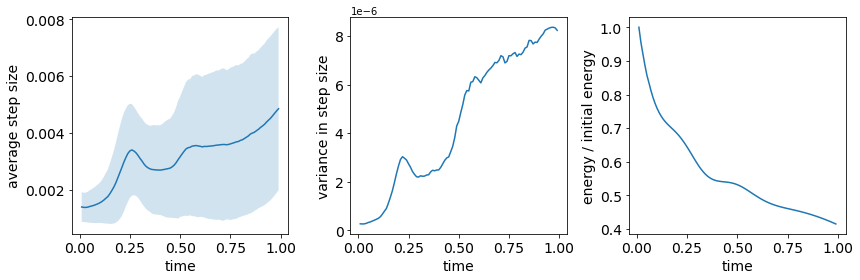

In [8]:
fig, axs = plt.subplots(figsize = (12,4), ncols = 3)


ax = axs[0]
x_values = np.array(tme_lst)
y_values = np.array(stepsize_mean_lst)
ax.plot(x_values, y_values)
ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('average step size',**axkwargs)
# plt.xticks(**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[1]
x_values = np.array(tme_lst)
y_values = np.array([s**2 for s in stepsize_std_lst])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('variance in step size',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[2]
x_values = np.array(tme_lst)
y_values = np.array(energy_lst)/energy_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('energy / initial energy',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

# ax = axs[2]
# x_values = np.array(tme_lst)
# y_values = np.array(volume_lst)/volume_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
# ax.plot(x_values, y_values)
# # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('volume / initial volume',**axkwargs)
# ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()

In [15]:
data_fn = f"avi_es_variable_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_salience_{salience}_stepsizeinit_{stepsize_init}')}_atolx_{atol_x}_btolx_{btol_x}.csv"

In [16]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [17]:
os.chdir(data_folder)
df.to_csv(data_fn, index=False)

In [ ]:
# "avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv"



# repeat with a larger learning rate (salience = 4)

In [18]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .05#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 4#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.0025#0.00001#0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.00001#0.001#1e-10; 
btol_v = 0.00001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_es_variable_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish
        Synchronous Variational Integrator 
        Explicit Newmark Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""


# TEXT = f"""
# TEXT=$'an inward squish with neural time steps
#         Asynchronous Variational Integrator 
#         Dormand–Prince Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [20]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
# learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

#let's try 100 bins
learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
        0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
        0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
        0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
        0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
        0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
        0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
        0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
        0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
        0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
        0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
        0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
        0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
        0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
        0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
        0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
        0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
        0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
        0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
        0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
        0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [0.00477609 0.00477838 0.00478067 0.00478296 0.00478526 0.00478755
 0.00478984 0.00479214 0.00479443 0.00479672 0.00479902 0.00480131
 0.0048036  0.0048059  0.00480819 0.00481048 0.00481277 0.00481507
 0.00481736 0.00481965 0.00482195 0.00482424 0.00482653 0.00482883
 0.00483112 0.00483341 0.00483571 0.004838   0.00484029 0.00484258
 0.00484488 0.00484717 0.00484946 0.00485176 0.00485405 0.00485634
 0.00485864 0.00486093 0.00486322 0.00486552 0.00486781 0.0048701
 0.0048724  0.00487469 0.00487698 0.00487927 0.00488157 0.00488386
 0.00488615 0.00488845 0.00489074 0.00489303 0.00489533 0.00489762
 0.00489991 0.00490221 0.0049045  0.00490679 0.00490908 0.00491138
 0.00491367 0.00491596 0.00491826 0.00492055 0.00492284 0.00492514
 0.00492743 0.00492972 0.00493202 0.00493431 0.0049366  0.0049389
 0.00494119 0.00494348 0.00494577 0.00494807 0.00495036 0.00495265
 0.00495495 0.00495724 0.00495953 0.00496183 0.00496412 0.00496641
 0.00496871 0.004971   0.00497329 0.00497558 0

In [21]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
# integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)

# integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [22]:
tB = 1.

#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tB
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
    integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
beep(3)

0.004852796376526191 0.0028680862480341476 0.004999999999999893


In [27]:
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}

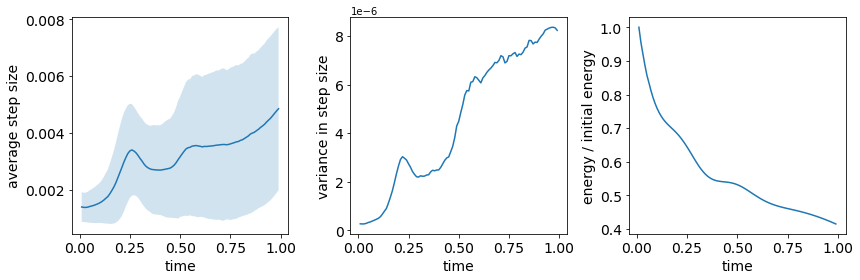

In [28]:
fig, axs = plt.subplots(figsize = (12,4), ncols = 3)


ax = axs[0]
x_values = np.array(tme_lst)
y_values = np.array(stepsize_mean_lst)
ax.plot(x_values, y_values)
ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('average step size',**axkwargs)
# plt.xticks(**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[1]
x_values = np.array(tme_lst)
y_values = np.array([s**2 for s in stepsize_std_lst])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('variance in step size',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[2]
x_values = np.array(tme_lst)
y_values = np.array(energy_lst)/energy_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('energy / initial energy',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

# ax = axs[2]
# x_values = np.array(tme_lst)
# y_values = np.array(volume_lst)/volume_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
# ax.plot(x_values, y_values)
# # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('volume / initial volume',**axkwargs)
# ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()

In [15]:
# data_fn = f"avi_es_variable_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_salience_{salience}_stepsizeinit_{stepsize_init}')}_atolx_{atol_x}_btolx_{btol_x}.csv"

In [29]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [31]:
os.chdir(data_folder)
df.to_csv(data_fn, index=False)
print(data_fn)

avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv


In [32]:
"avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv"



'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv'

# repeat with a smaller learning rate (salience = .5)

In [33]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .05#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 0.5#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.0025#0.00001#0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.00001#0.001#1e-10; 
btol_v = 0.00001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_es_variable_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish
        Synchronous Variational Integrator 
        Explicit Newmark Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""


# TEXT = f"""
# TEXT=$'an inward squish with neural time steps
#         Asynchronous Variational Integrator 
#         Dormand–Prince Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [38]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
learning_bins = np.array(sorted([stepsize_init*frac_lb(i) for i in np.arange(-15,15)]))

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

# #let's try 100 bins
# learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
#         0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
#         0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
#         0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
#         0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
#         0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
#         0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
#         0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
#         0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
#         0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
#         0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
#         0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
#         0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
#         0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
#         0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
#         0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
#         0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
#         0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
#         0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
#         0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
#         0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [1.52587891e-07 3.05175781e-07 6.10351563e-07 1.22070312e-06
 2.44140625e-06 4.88281250e-06 9.76562500e-06 1.95312500e-05
 3.90625000e-05 7.81250000e-05 1.56250000e-04 3.12500000e-04
 6.25000000e-04 1.25000000e-03 2.50000000e-03 5.00000000e-03
 1.00000000e-02 2.00000000e-02 4.00000000e-02 8.00000000e-02
 1.60000000e-01 3.20000000e-01 6.40000000e-01 1.28000000e+00
 2.56000000e+00 5.12000000e+00 1.02400000e+01 2.04800000e+01
 4.09600000e+01 8.19200000e+01]


In [36]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
# integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)

# integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [39]:
tB = 1.

#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tB
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
    integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
beep(2)

0.004900920638046561 0.0028864944399452654 0.004999999999999893


0

In [40]:
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}

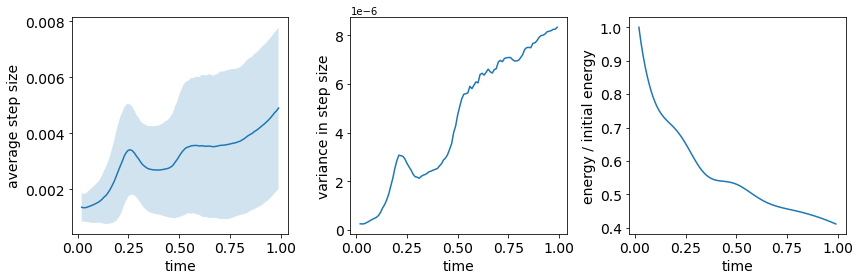

In [41]:
fig, axs = plt.subplots(figsize = (12,4), ncols = 3)


ax = axs[0]
x_values = np.array(tme_lst)
y_values = np.array(stepsize_mean_lst)
ax.plot(x_values, y_values)
ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('average step size',**axkwargs)
# plt.xticks(**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[1]
x_values = np.array(tme_lst)
y_values = np.array([s**2 for s in stepsize_std_lst])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('variance in step size',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[2]
x_values = np.array(tme_lst)
y_values = np.array(energy_lst)/energy_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('energy / initial energy',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

# ax = axs[2]
# x_values = np.array(tme_lst)
# y_values = np.array(volume_lst)/volume_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
# ax.plot(x_values, y_values)
# # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('volume / initial volume',**axkwargs)
# ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()

In [15]:
# data_fn = f"avi_es_variable_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_salience_{salience}_stepsizeinit_{stepsize_init}')}_atolx_{atol_x}_btolx_{btol_x}.csv"

In [42]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [43]:
os.chdir(data_folder)
df.to_csv(data_fn, index=False)
print(data_fn)

avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv


In [44]:
"avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv"



'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv'

# (salience = 0.5) with step size initialized to 0.005

In [76]:
#define Lamé parameters
mu = 1.; lam = 10.; 
#define coefficient for Rayleigh damping
gamma = .05#1.#1.;

#define adaptive time stepping absolute tolerances
salience = 2#128#32
learning_rate = np.log(salience) #np.log(16) #np.log(2)
lasso_fraction = 0.5
v_scale = 2.
mass_density=1.

stepsize_init = 0.005#0.00001#0.0001
atol_x = 0.0001#0.001#1e-7; 
atol_v = 0.0001#0.001#1e-7; 
btol_x = 0.00001#0.001#1e-10; 
btol_v = 0.00001#0.001#1e-10; 


#path to mesh
input_file_name = f'../data/spherical_meshes/spherical_mesh_400.stl'
#where to save results
data_folder =  os.path.join(nb_dir,'../data/mov_csv')
data_fn = f"avi_es_variable_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
# data_fn = f"avi_ns_fixed_lr_a_equal_b_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}vscale_{v_scale}_stepsizeinit_{stepsize_init}')}_salience_{salience}_atolx_{atol_x}.csv"
save_folder_vid = '../vid/tmp'
folder_vid = '../vid'
# data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npz')
data_fn_counts = data_fn.replace("s_","s_counts_").replace('.csv','.npy')

os.chdir(nb_dir)
# input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'input_file_name = f'../data/spherical_meshes/spherical_mesh_64.stl'
# input_file_name = f'../data/spherical_meshes/spherical_mesh_1000.stl'
input_file_name = os.path.join(nb_dir,input_file_name)
tme = 0.
dict_values_system = initialize_system(input_file_name, time_initial=tme, mass_density=mass_density)
locals().update(dict_values_system)
N_elements = element_array_index.shape[0]
N_vertices = node_array_position.shape[0]
print(list(dict_values_system.keys()))

#header to start of video
# TEXT = '''TEXT=$'Synchronous Variational Integrator\nDamped Neohookean Model\n(inward squish)''''
TEXT = f"""
TEXT=$'an inward squish
        Synchronous Variational Integrator 
        Explicit Newmark Method
        
        Undamped Neohookean Model
        mu {mu}  lambda {lam} gamma {gamma}
        
        Spherical Mesh
        Num. Vertices {N_vertices}
        Num. Elements {N_elements}
'"""


# TEXT = f"""
# TEXT=$'an inward squish with neural time steps
#         Asynchronous Variational Integrator 
#         Dormand–Prince Method
        
#         Undamped Neohookean Model
#         mu {mu}  lambda {lam} gamma {gamma}
        
#         Spherical Mesh
#         Num. Vertices {N_vertices}
#         Num. Elements {N_elements}
# '"""

#write header to file
# print(TEXT)
# Dormand–Prince Method
# Explicit Newmark Method
# Implicit Midpoint Rule

face_normals all zero, ignoring!


['element_array_time', 'element_array_index', 'element_array_mass', 'element_array_volume', 'element_array_inverse_equilibrium_position', 'node_array_equilibrium_position', 'node_array_time', 'node_array_position', 'node_array_momentum', 'node_array_mass', 'node_array_volume']


In [77]:
#initialize system
tauK = element_array_time
tau = node_array_time

#get method of computing elastic forces 
zero_mat = np.zeros((4,3))
# calc_P = get_calc_P(mu, lam)
# compute_nodal_damping_forces  = get_compute_nodal_damping_forces(mu,lam,gamma)
# comp_nodal_elastic_forces = get_comp_nodal_elastic_forces(mu, lam)

elements = element_array_index
vertices = node_array_position

#initialize stepsizes of simulation
element_array_stepsize = np.zeros_like(element_array_time) + stepsize_init
element_array_count_calls_one_step = np.zeros_like(element_array_time,dtype=int)
element_array_count_config_updates = np.zeros_like(element_array_time,dtype=int)
momentum = node_array_momentum.copy()
velocities = momentum.copy()
for j in range(N_vertices):
    velocities[j] /= node_array_mass[j]


# #perturb momentum in the x direction and let it run overnight with a small timestep  
velocities[:,0] = -v_scale * vertices[:,0].copy()

#initialize containers of measures
volume_lst = []
energy_lst = []
tme_lst    = []
stepsize_mean_lst   = []
stepsize_std_lst    = []
stepsize_median_lst = []
stepsize_count_lst = []
frac_lb = lambda i: np.exp(learning_rate*i)  ##np.exp((i+.5)*learning_rate/10)
# learning_bins = np.array([stepsize_init*frac_lb(i) for i in np.arange(-15,15)])

# #this looks nice. 30 bins
# learning_bins = np.array([0.00480198, 0.00480886, 0.00481574, 0.00482262, 0.00482951,
#         0.00483639, 0.00484327, 0.00485015, 0.00485703, 0.00486391,
#         0.0048708 , 0.00487768, 0.00488456, 0.00489144, 0.00489832,
#         0.0049052 , 0.00491209, 0.00491897, 0.00492585, 0.00493273,
#         0.00493961, 0.00494649, 0.00495338, 0.00496026, 0.00496714,
#         0.00497402, 0.0049809 , 0.00498778, 0.00499467, 0.00500155,
#         0.00500843])

#let's try 100 bins
learning_bins = np.array([0.00477609, 0.00477838, 0.00478067, 0.00478296, 0.00478526,
        0.00478755, 0.00478984, 0.00479214, 0.00479443, 0.00479672,
        0.00479902, 0.00480131, 0.0048036 , 0.0048059 , 0.00480819,
        0.00481048, 0.00481277, 0.00481507, 0.00481736, 0.00481965,
        0.00482195, 0.00482424, 0.00482653, 0.00482883, 0.00483112,
        0.00483341, 0.00483571, 0.004838  , 0.00484029, 0.00484258,
        0.00484488, 0.00484717, 0.00484946, 0.00485176, 0.00485405,
        0.00485634, 0.00485864, 0.00486093, 0.00486322, 0.00486552,
        0.00486781, 0.0048701 , 0.0048724 , 0.00487469, 0.00487698,
        0.00487927, 0.00488157, 0.00488386, 0.00488615, 0.00488845,
        0.00489074, 0.00489303, 0.00489533, 0.00489762, 0.00489991,
        0.00490221, 0.0049045 , 0.00490679, 0.00490908, 0.00491138,
        0.00491367, 0.00491596, 0.00491826, 0.00492055, 0.00492284,
        0.00492514, 0.00492743, 0.00492972, 0.00493202, 0.00493431,
        0.0049366 , 0.0049389 , 0.00494119, 0.00494348, 0.00494577,
        0.00494807, 0.00495036, 0.00495265, 0.00495495, 0.00495724,
        0.00495953, 0.00496183, 0.00496412, 0.00496641, 0.00496871,
        0.004971  , 0.00497329, 0.00497558, 0.00497788, 0.00498017,
        0.00498246, 0.00498476, 0.00498705, 0.00498934, 0.00499164,
        0.00499393, 0.00499622, 0.00499852, 0.00500081, 0.0050031 ,
        0.00500539])

# learning_bins = np.array([stepsize_init*np.exp((i+.5)*learning_rate) for i in np.arange(-3,3)])
print(f"learning_bins are {learning_bins}")

learning_bins are [0.00477609 0.00477838 0.00478067 0.00478296 0.00478526 0.00478755
 0.00478984 0.00479214 0.00479443 0.00479672 0.00479902 0.00480131
 0.0048036  0.0048059  0.00480819 0.00481048 0.00481277 0.00481507
 0.00481736 0.00481965 0.00482195 0.00482424 0.00482653 0.00482883
 0.00483112 0.00483341 0.00483571 0.004838   0.00484029 0.00484258
 0.00484488 0.00484717 0.00484946 0.00485176 0.00485405 0.00485634
 0.00485864 0.00486093 0.00486322 0.00486552 0.00486781 0.0048701
 0.0048724  0.00487469 0.00487698 0.00487927 0.00488157 0.00488386
 0.00488615 0.00488845 0.00489074 0.00489303 0.00489533 0.00489762
 0.00489991 0.00490221 0.0049045  0.00490679 0.00490908 0.00491138
 0.00491367 0.00491596 0.00491826 0.00492055 0.00492284 0.00492514
 0.00492743 0.00492972 0.00493202 0.00493431 0.0049366  0.0049389
 0.00494119 0.00494348 0.00494577 0.00494807 0.00495036 0.00495265
 0.00495495 0.00495724 0.00495953 0.00496183 0.00496412 0.00496641
 0.00496871 0.004971   0.00497329 0.00497558 0

In [78]:
#choose your fighter
# integrate_system_explicit_synchronous = get_integrate_system_explicit_synchronous(mu,lam,gamma)
# integrate_system_implicit_synchronous = get_integrate_system_implicit_synchronous(mu,lam,gamma,num_iter=30)
# integrate_system_dormand_prince_synchronous = get_integrate_system_dormand_prince_synchronous(mu,lam,gamma)
# integrate_system_dormand_prince_asynchronous = get_integrate_system_dormand_prince_asynchronous(mu,lam,gamma,atol_x, atol_v, btol_x, btol_v,learning_rate, lasso_fraction)
integrate_system_explicit_asynchronous = get_integrate_system_explicit_asynchronous(mu,lam,gamma)

#(optional) #view the mesh
# plot_mesh(vertices, input_file_name=input_file_name, darkmode=True)

In [79]:
tB = 1.

#prepare for video
frameno = 1
time_between_observations = 0.01
time_end_recording = tB
time_of_next_observation = tme + time_between_observations

#ready... get set... GO!
os.chdir(nb_dir)
os.chdir(save_folder_vid)

while time_of_next_observation <= time_end_recording:
    tf = time_of_next_observation
    #integrate forward to the next time of observation
#     integrate_system_explicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
#                                              element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_implicit_synchronous(tf, element_array_time, element_array_stepsize, node_array_time,
    #                                          element_array_index, vertices, velocities,node_array_mass, element_array_inverse_equilibrium_position)
    #     integrate_system_dormand_prince_asynchronous(tf,element_array_time,element_array_stepsize,node_array_time,element_array_index,vertices,velocities,
    #         node_array_mass,element_array_inverse_equilibrium_position,element_array_mass)
    integrate_system_explicit_asynchronous(tf, element_array_time, element_array_stepsize, node_array_time,
                                             element_array_index, vertices, velocities, node_array_mass, element_array_inverse_equilibrium_position, atol_x, atol_v, btol_x, btol_v, learning_rate)

    #update a copy of all positions to the observation time using the current velocity
    x = vertices.copy()
    for a in range(N_vertices):
        x[a] += velocities[a] * (tf - tau[a])
    
    #measure observables
    ##mesh measures
    net_volume = compute_net_volume(x, element_array_index)
    net_energy = compute_net_energy(N_elements, element_array_mass, velocities, x, #vertices,
                                  element_array_index, element_array_inverse_equilibrium_position, mu, lam)
    ##stepsize measures
    stepsize_mean = np.mean(element_array_stepsize)
    stepsize_std = np.std(element_array_stepsize)
    stepsize_median = np.median(element_array_stepsize)

    #record observables
    volume_lst.append(net_volume)
    energy_lst.append(net_energy)
    tme = tf
    tme_lst.append(tme)
    stepsize_mean_lst.append(stepsize_mean)
    stepsize_std_lst.append(stepsize_std)
    stepsize_median_lst.append(stepsize_median)
    stepsize_count_lst.append(count_array(array = element_array_stepsize,bins=learning_bins))
    #record image of system
#     try:
#         img = get_img_of_system(vertices, input_file_name, darkmode = False, text=f'time={tf:.2f}')
#     except:
#         pass
#     save_fn_img = f'img{frameno:09}.png'
#     frameno += 1
#     Img = Image.fromarray(img)
# #     Img.save(save_fn_img)


#     del Img
    #increment time_of_next_observation
    time_of_next_observation += time_between_observations
    #TODO(later): do something that makes a boring video less boring
    #TODO(later): def element_array_count_calls_one_step to the call of integrate_system_.... i.e. Keep track of how many times each element is called to time step
    #TODO(later): keep track of how many times each element config is updated with element_array_count_config_updates
print(stepsize_mean, stepsize_std, stepsize_median)
# beep(3)

/Users/timothytyree/Documents/GitHub/avi/nb/lib/controller/integrate_forward_explicit_asynchronous.py:45: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  next_stepsize, retval, madval = step_forward_and_learn_simple(K_index, t_given, node_array_time, element_array_time, vertices, velocities, element_array_index,


0.004879627806222941 0.002904086515731493 0.004999999999999893


In [80]:
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}

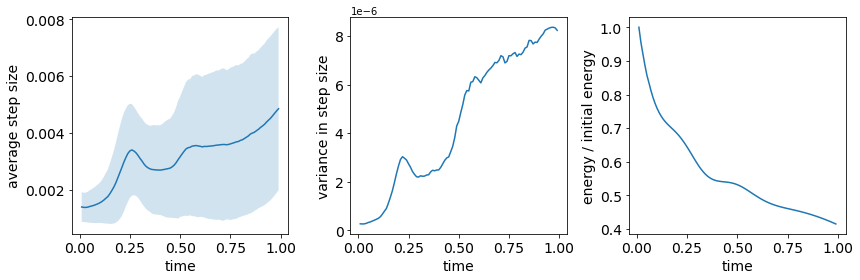

In [8]:
fig, axs = plt.subplots(figsize = (12,4), ncols = 3)


ax = axs[0]
x_values = np.array(tme_lst)
y_values = np.array(stepsize_mean_lst)
ax.plot(x_values, y_values)
ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('average step size',**axkwargs)
# plt.xticks(**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[1]
x_values = np.array(tme_lst)
y_values = np.array([s**2 for s in stepsize_std_lst])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('variance in step size',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

ax = axs[2]
x_values = np.array(tme_lst)
y_values = np.array(energy_lst)/energy_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
ax.plot(x_values, y_values)
# ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
ax.set_xlabel('time',**axkwargs)
ax.set_ylabel('energy / initial energy',**axkwargs)
ax.tick_params(labelsize=axkwargs['fontsize'])

# ax = axs[2]
# x_values = np.array(tme_lst)
# y_values = np.array(volume_lst)/volume_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
# ax.plot(x_values, y_values)
# # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('volume / initial volume',**axkwargs)
# ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()

In [15]:
data_fn = f"avi_es_variable_lr_{os.path.basename(input_file_name).replace('.stl',f'_mu_{mu}_lambda_{lam}_gamma_{gamma}_vscale_{v_scale}_salience_{salience}_stepsizeinit_{stepsize_init}')}_atolx_{atol_x}_btolx_{btol_x}.csv"

In [16]:
df = pd.DataFrame({
    't':tme_lst,
    'volume':volume_lst,
    'energy':energy_lst,
    'stepsize_mean':stepsize_mean_lst,
    'stepsize_std':stepsize_std_lst,
    'stepsize_median':stepsize_median_lst,
})

In [17]:
os.chdir(data_folder)
df.to_csv(data_fn, index=False)

In [ ]:
# "avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv"



# Plot the three cases

In [68]:
fn  = "avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv"
fnA = 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv'
fnB = 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv'
fnC = 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv'
os.chdir(data_folder)



In [72]:
df = pd.read_csv(fnB)
dfA.head()

FileNotFoundError: [Errno 2] File avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv does not exist: 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv'

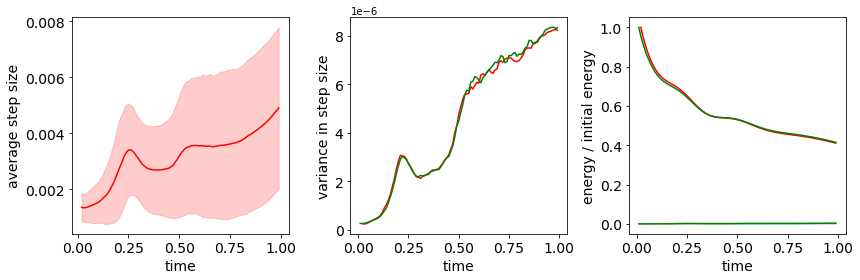

In [75]:
fig, axs = plt.subplots(figsize = (12,4), ncols = 3)


ax = axs[0]
color_lst = ['red','green']
fn_lst = [fnA,fnC]
for color,fn in zip(color_lst,fn_lst):
    df = pd.read_csv(fn)
    x_values = np.array(df['t'])
    y_values = np.array(df['stepsize_mean'])
    ax.plot(x_values, y_values, color=color)
    ax.fill_between(x_values, y_values-df['stepsize_std'],y_values+df['stepsize_std'], alpha=0.2, color=color)
    ax.set_xlabel('time',**axkwargs)
    ax.set_ylabel('average step size',**axkwargs)
    # plt.xticks(**axkwargs)
    ax.tick_params(labelsize=axkwargs['fontsize'])

    ax = axs[1]
    x_values = np.array(df['t'])
    y_values = np.array(df['stepsize_std']**2)
    ax.plot(x_values, y_values, color=color)
    # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
    ax.set_xlabel('time',**axkwargs)
    ax.set_ylabel('variance in step size',**axkwargs)
    ax.tick_params(labelsize=axkwargs['fontsize'])

    ax = axs[2]
    energy_lst = list(df['energy'].values)
    x_values = np.array(df['t'])
    y_values = np.array(energy_lst)/energy_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
    ax.plot(x_values, y_values, color=color)
    # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
    ax.set_xlabel('time',**axkwargs)
    ax.set_ylabel('energy / initial energy',**axkwargs)
    ax.tick_params(labelsize=axkwargs['fontsize'])

# ax = axs[2]
# x_values = np.array(tme_lst)
# y_values = np.array(volume_lst)/volume_lst[0]#[s**2/m for s,m in zip(stepsize_std_lst,stepsize_mean_lst)])
# ax.plot(x_values, y_values)
# # ax.fill_between(x_values, y_values-stepsize_std_lst,y_values+stepsize_std_lst, alpha=0.2)
# ax.set_xlabel('time',**axkwargs)
# ax.set_ylabel('volume / initial volume',**axkwargs)
# ax.tick_params(labelsize=axkwargs['fontsize'])

plt.tight_layout()
plt.show()

In [61]:
color_lst = ['red','blue','green']
fn_lst = [fnA,fnB,fnC]
for color,fn in zip(color_lst,fn_lst):
    df = pd.read_csv(fn)

FileNotFoundError: [Errno 2] File avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv does not exist: 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_2_atolx_0.0001.csv'

In [60]:
!ls -l

total 2856
-rw-r--r--  1 timothytyree  staff   69728 Dec 10 17:00 avi_es_counts_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.npy
-rw-r--r--  1 timothytyree  staff      22 Dec  9 18:33 avi_es_counts_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.npy.npz
-rw-r--r--  1 timothytyree  staff   35726 Dec 10 17:00 avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv
-rw-r--r--  1 timothytyree  staff   18587 Dec 10 15:25 avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_2.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv
-rw-r--r--@ 1 timothytyree  staff   34037 Dec  9 18:31 avi_es_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv
-rw-r--r--  1 timothytyree  staff   11802 Dec 10 19:55 avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_at

In [62]:
fn = "avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv"
df = pd.read_csv(fn)

avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv
avi_es_fixed_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv
avi_es_fixed_lr_a_equal_b_spherical_mesh_64_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv
avi_es_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv
avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv
avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv
avi_es_variable_lr_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_salience_2_stepsizeinit_0.0025_atolx_0.0001_btolx_1e-05.csv


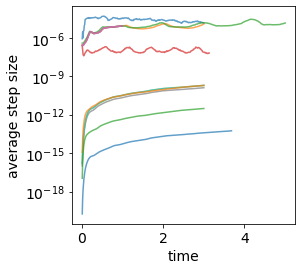

In [93]:
fig, axs = plt.subplots(figsize = (4,4), ncols = 1)
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}

ax = axs
# color_lst = [None, None]
os.chdir(data_folder)
fn_lst = sorted([fn for fn in os.listdir() if fn.find('.csv')!=-1])
# fn_lst = !grep *.csv
#[fnA, fnB]
# color_lst = ['green']
# fn_lst = [ fnB]
os.chdir(data_folder)
color = None
# for color,fn in zip(color_lst,fn_lst):
for fn in fn_lst:
    df = pd.read_csv(fn)
    x_values = np.array(df['t'])
    
    y_values = np.array(df['stepsize_std']**2)
    ymean = np.mean(y_values)
    if ymean >= 1e-30:
        p = ax.plot(x_values, y_values, color=color, alpha=.7)
        clr = p[0].get_color()
    #     ax.fill_between(x_values, y_values-df['stepsize_std'],y_values+df['stepsize_std'], alpha=0.2, color=clr)
    ax.set_xlabel('time',**axkwargs)
    ax.set_ylabel('average step size',**axkwargs)
    ax.set_yscale('log')
    # plt.xticks(**axkwargs)
    ax.tick_params(labelsize=axkwargs['fontsize'])
    if ymean >= 1e-9:
        print(fn)

2.6765431984138072e-05, avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv
6.512177379461233e-06, avi_es_fixed_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv
9.982976854423984e-06, avi_es_fixed_lr_a_equal_b_spherical_mesh_64_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv
1.0853389324093755e-07, avi_es_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv
4.527980484913064e-06, avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv
4.513824033625072e-06, avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv
4.513824033625072e-06, avi_es_variable_lr_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_salience_2_stepsizeinit_0

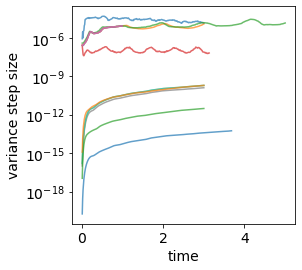

In [113]:
fig, axs = plt.subplots(figsize = (4,4), ncols = 1)
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}

ax = axs
# color_lst = [None, None]
os.chdir(data_folder)
fn_lst = sorted([fn for fn in os.listdir() if fn.find('.csv')!=-1])
# fn_lst = !grep *.csv
#[fnA, fnB]

fn_lst_myneural2 = [] 
# color_lst = ['green']
# fn_lst = [ fnB]
os.chdir(data_folder)
color = None
# for color,fn in zip(color_lst,fn_lst):
for fn in fn_lst:
    df = pd.read_csv(fn)
    x_values = np.array(df['t'])
    
    y_values = np.array(df['stepsize_std']**2)
    ymean = np.mean(y_values)
    if ymean >= 1e-30:
        p = ax.plot(x_values, y_values, color=color, alpha=.7)
        clr = p[0].get_color()
    #     ax.fill_between(x_values, y_values-df['stepsize_std'],y_values+df['stepsize_std'], alpha=0.2, color=clr)
    ax.set_xlabel('time',**axkwargs)
    ax.set_ylabel('variance step size',**axkwargs)
    ax.set_yscale('log')
    # plt.xticks(**axkwargs)
    ax.tick_params(labelsize=axkwargs['fontsize'])
    if (ymean >= 1e-9) & (ymean>= 1e-30):
        print(f"{ymean}, {fn}")
        fn_lst_myneural2.append(fn)
        

Note fn_lst_myneural contains only fixed time step methods

In [117]:
fn_lst_myneural = ['avi_ns_a_equal_b_spherical_mesh_100_mu_1.0_lambda_1.0_gamma_0.0vscale_2.0_stepsizeinit_0.005.csv',
 'avi_ns_a_equal_b_spherical_mesh_100_mu_1.0_lambda_1.0_gamma_0.0vscale_2.0_stepsizeinit_0.005_salience_32.csv',
 'avi_ns_a_equal_b_spherical_mesh_100_mu_1.0_lambda_1.0_gamma_0.0vscale_2.0_stepsizeinit_0.005_salience_32_atolx_0.0001.csv',
 'avi_ns_a_equal_b_spherical_mesh_100_mu_1.0_lambda_1.0_gamma_0.0vscale_2.0_stepsizeinit_5e-05_salience_128_atolx_0.0001.csv',
 'avi_ns_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0vscale_2.0_stepsizeinit_0.005.csv',
 'avi_ns_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv']

NameError: name 'fn_lst_myneural3' is not defined

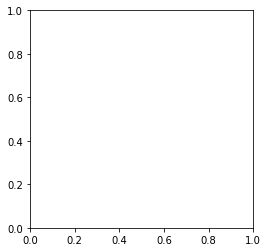

In [118]:
fig, axs = plt.subplots(figsize = (4,4), ncols = 1)
bins = 30
axkwargs = {
    'fontsize':14,
    
}
hkwargs = {
    'color':'blue',#'orange',
    'cumulative':False,
    'stacked':True,
    'log':False,
    'density':False,
    'bins':bins
}


os.chdir(data_folder)
color = None
# for color,fn in zip(color_lst,fn_lst):
for fn in fn_lst_myneural3:
    df = pd.read_csv(fn)
    x_values = np.array(df['t'])
    y_values = np.array(df['stepsize_std']**2)
    ymean = np.mean(y_values)
    p = ax.plot(x_values, y_values, color=color, alpha=.7)
    clr = p[0].get_color()
    #     ax.fill_between(x_values, y_values-df['stepsize_std'],y_values+df['stepsize_std'], alpha=0.2, color=clr)
#     ax.set_xlabel('time',**axkwargs)
#     ax.set_ylabel('average step size',**axkwargs)
#     ax.set_yscale('log')




In [119]:
df

,t,volume,energy,stepsize_mean,stepsize_std,stepsize_median
0,0.01,4.122988,0.422046,0.0001,2.710505e-20,0.0001
1,0.02,4.081341,0.429522,0.0001,2.710505e-20,0.0001
2,0.03,4.039695,0.441962,0.0001,2.710505e-20,0.0001
3,0.04,3.993702,0.461895,0.0001,2.710505e-20,0.0001
4,0.05,3.947293,0.488982,0.0001,2.710505e-20,0.0001
...,...,...,...,...,...,...
339,3.40,10.673917,NaN,0.0001,2.710505e-20,0.0001
340,3.41,10.720419,NaN,0.0001,2.710505e-20,0.0001
341,3.42,10.766923,NaN,0.0001,2.710505e-20,0.0001
342,3.43,10.813429,NaN,0.0001,2.710505e-20,0.0001


In [120]:
fn_lst_myneural2 = ['avi_es_fixed_lr_a_equal_b_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0_vscale_1.0_stepsizeinit_0.0001_salience_2_atolx_0.0001.csv',
 'avi_es_fixed_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv',
 'avi_es_fixed_lr_a_equal_b_spherical_mesh_64_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.005_salience_2_atolx_0.0001.csv',
 'avi_es_spherical_mesh_100_mu_1.0_lambda_10.0_gamma_0.0.csv',
 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_0.5_atolx_0.0001.csv',
 'avi_es_variable_lr_a_equal_b_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_stepsizeinit_0.0025_salience_4_atolx_0.0001.csv',
 'avi_es_variable_lr_spherical_mesh_400_mu_1.0_lambda_10.0_gamma_0.05_vscale_2.0_salience_2_stepsizeinit_0.0025_atolx_0.0001_btolx_1e-05.csv']